# Probabilistic matrix factorization

The following implementation is modified from the [example in the PyMC3 documentation](https://pymc-devs.github.io/pymc3/notebooks/pmf-pymc.html).  The original credit goes to Ruslan Salakhutdinov, Andriy Mnih, Mack Sweeney.

### Motivation

We have a dataset of jokes.  If you read say 5 out of 100 of these jokes and then rate them on a scale -10 to 10.  If would be nice to have a little program that takes this info and outputs all 100 jokes with your estimated preferences.

### Intuition

One intuitive way to estimate preferences is to find other users who like similar jokes.  How we define what is similar is not always straightforward so we often like to use factors or topics to help guide our similarity.  We might consider jokes as having the following properties: dry, sarcastic, crude, sexual, political, etc.  We could then obtaina use a 0,1 vector representation of a _humor profile_.

If we go back to those 5 jokes you rated and took a look at the humor profiles we might get some insight into your  preferences.  We could devise a system to calculate similarity between all users and then when we predict our own preferences we would heavily weight the most similar user preferences when making predicitons.  

We could also use the humor profile, through comparisions with other humor profiles, to make suggestions to a paritcular user.  Both of these methods are called _neighborhood approaches_.  If we leverage both of these things together the technique is generally referred to as **collaborative filtering**.

### Formalization

* Say we have $M$ jokes and $N$ users
* For each item, we model it with a D-dimensional latent factor composition (humor profile above)
* The only thing we get to observe is the $N×M$ ratings matrix $R$
* Entry $R_{ij}$ is the rating user $i$ gave to item $j$

Many ratings will be missing and our goal is to fill in those missing values.

* For convenience we also use an indicator matrix $I$, with entry $I_{ij}=0$ if $R_{ij}$ is missing and $I_{ij}=1$ otherwise.

To help with bookkeeping say we also have

* $U$ an $N×D$ matrix of user preferences
* $V$ an $M×D$ factor composition matrix

We can think of each row $U_{i}$ as indications of how much each user prefers each of the $D$ latent factors.  

Each row $V_{j}$ can be thought of as how much each item can be described by each of the latent factors.

We also need a suitable **prediction function** which maps a user preference vector $U_{i}$ and an item latent factor vector $V_{j}$ to a predicted ranking. The choice of this prediction function is an important modeling and one of the most common ones is the dot product of the two vectors.

For the sake of example lets say that we have five latent factors. 

In [33]:
import numpy as np

Ui = np.array([0.2,0.1,0.3,0.1,0.3]) # a user profile
Vj = np.array([0.5,0.5,0.25,0.8,0.9]) # an item profile
print("User i's preference for item j = %s"%(np.dot(Ui,Vj.T)))

User i's preference for item j = 0.575


## The data

The original data set can be [downloaded here](http://eigentaste.berkeley.edu/dataset).  For illustrative purposes we use the subset that was used in the PyMC3 documentation.

In [34]:
import pandas as pd
import os
import shutil

import matplotlib.pyplot as plt
%matplotlib inline
%precision 4

plt.style.use('bmh')
DATA_DIR = './data'

file_path = os.path.join(DATA_DIR,'jester-dataset-v1-dense-first-1000.csv')

#jester-dataset-v1-dense-first-1000.csv
data = pd.read_csv(file_path)
data.head()

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,...,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
1,-6.17,-3.54,0.44,-8.50,-7.09,-4.32,-8.69,-0.87,-6.65,-1.80,...,-3.54,-6.89,-0.68,-2.96,-2.18,-3.35,0.05,-9.08,-5.05,-3.45
2,6.84,3.16,9.17,-6.21,-8.16,-1.70,9.27,1.41,-5.19,-4.42,...,7.23,-1.12,-0.10,-5.68,-3.16,-3.35,2.14,-0.05,1.31,0.00
3,-3.79,-3.54,-9.42,-6.89,-8.74,-0.29,-5.29,-8.93,-7.86,-1.60,...,4.37,-0.29,4.17,-0.29,-0.29,-0.29,-0.29,-0.29,-3.40,-4.95
4,1.31,1.80,2.57,-2.38,0.73,0.73,-0.97,5.00,-7.23,-1.36,...,1.46,1.70,0.29,-3.30,3.45,5.44,4.08,2.48,4.51,4.66


### EDA

(-11, 11)

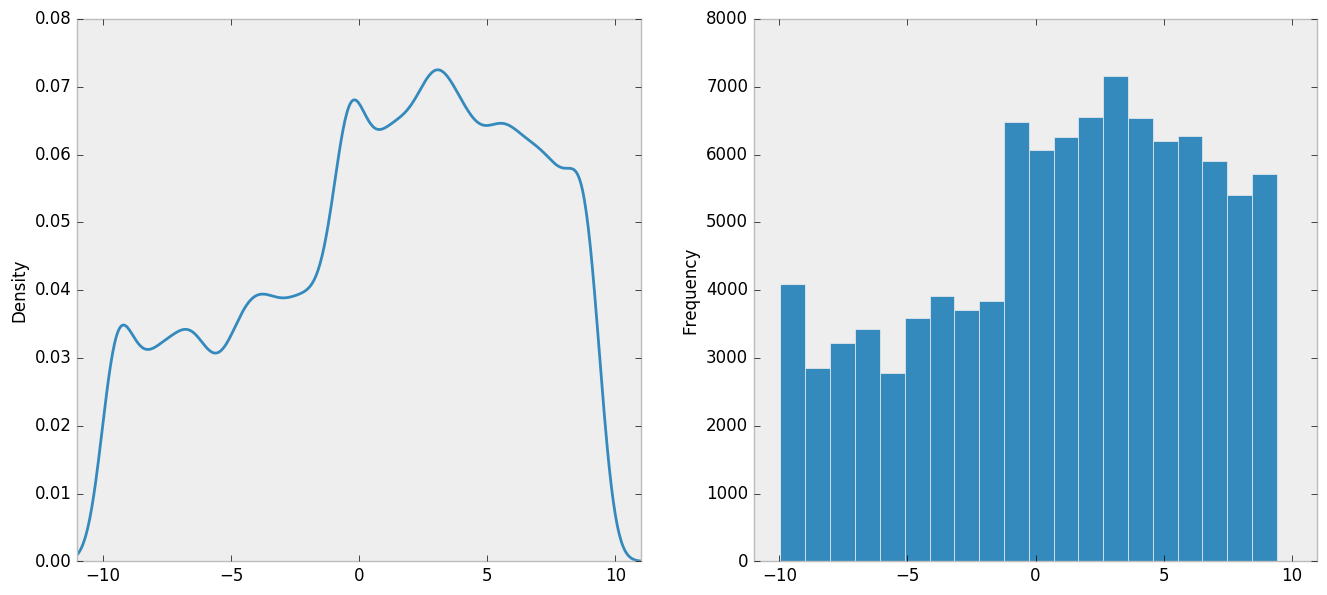

In [35]:
# Extract the ratings from the DataFrame
all_ratings = np.ndarray.flatten(data.values)
ratings = pd.Series(all_ratings)

# Plot histogram and density.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
ratings.plot(kind='density', ax=ax1, grid=False,fontsize=12)
ax1.set_ylim(0, 0.08)
ax1.set_xlim(-11, 11)

# Plot histogram
ratings.plot(kind='hist', ax=ax2, bins=20, grid=False, fontsize=12)
ax2.set_xlim(-11, 11)

In [36]:
ratings.describe()

count    100000.000000
mean          0.996219
std           5.265215
min          -9.950000
25%          -2.860000
50%           1.650000
75%           5.290000
max           9.420000
dtype: float64

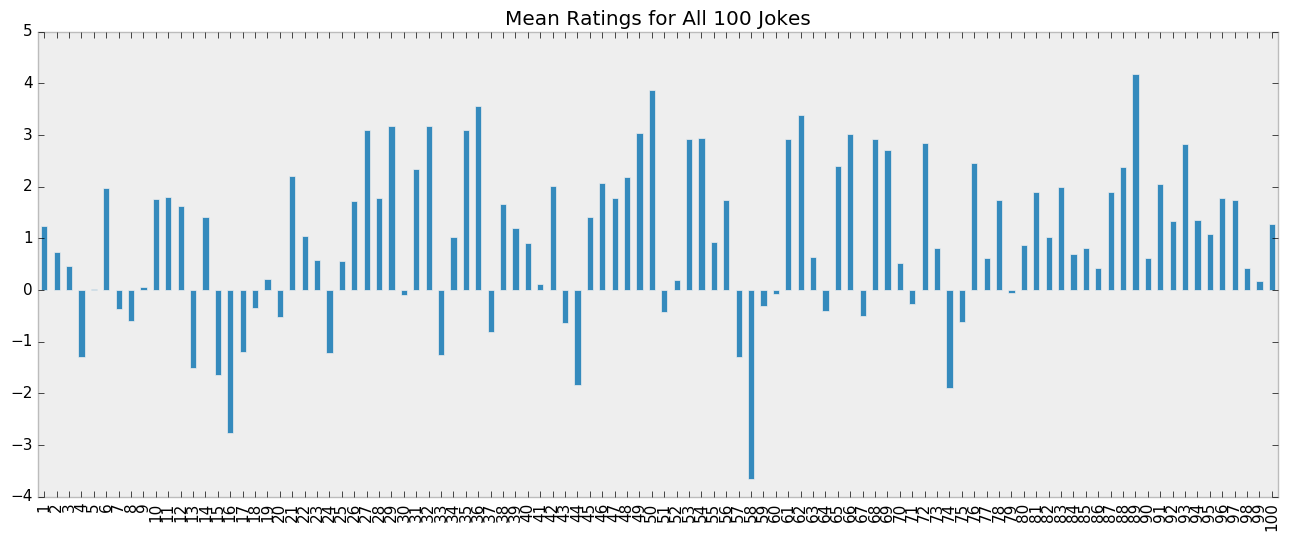

In [37]:
## look at joke means
joke_means = data.mean(axis=0)
ax = joke_means.plot(kind='bar', grid=False, figsize=(16, 6),
                    title="Mean Ratings for All 100 Jokes", fontsize=11)

In [38]:
import json

# Worst and best joke?
worst_joke_id = joke_means.argmin()
best_joke_id = joke_means.argmax()

# Let's see for ourselves. Load the jokes.
with open(os.path.join(DATA_DIR, 'jokes.json')) as buff:
    joke_dict = json.load(buff)

print('The worst joke:\n---------------\n%s\n' % joke_dict[worst_joke_id])
print('The best joke:\n--------------\n%s' % joke_dict[best_joke_id])

The worst joke:
---------------
How many teddybears does it take to change a lightbulb?

It takes only one teddybear, but it takes a whole lot of lightbulbs.


The best joke:
--------------
*A radio conversation of a US naval 
ship with Canadian authorities ... *

Americans: Please divert your course 15 degrees to the North to avoid a
collision.

Canadians: Recommend you divert YOUR course 15 degrees to the South to 
avoid a collision.

Americans: This is the Captain of a US Navy ship.  I say again, divert 
YOUR course.

Canadians: No.  I say again, you divert YOUR course.

Americans: This is the aircraft carrier USS LINCOLN, the second largest ship in the United States' Atlantic Fleet. We are accompanied by three destroyers, three cruisers and numerous support vessels. I demand that you change your course 15 degrees north, that's ONE FIVE DEGREES NORTH, or counter-measures will be undertaken to ensure the safety of this ship.

Canadians: *This is a lighthouse.  Your call*.



[]

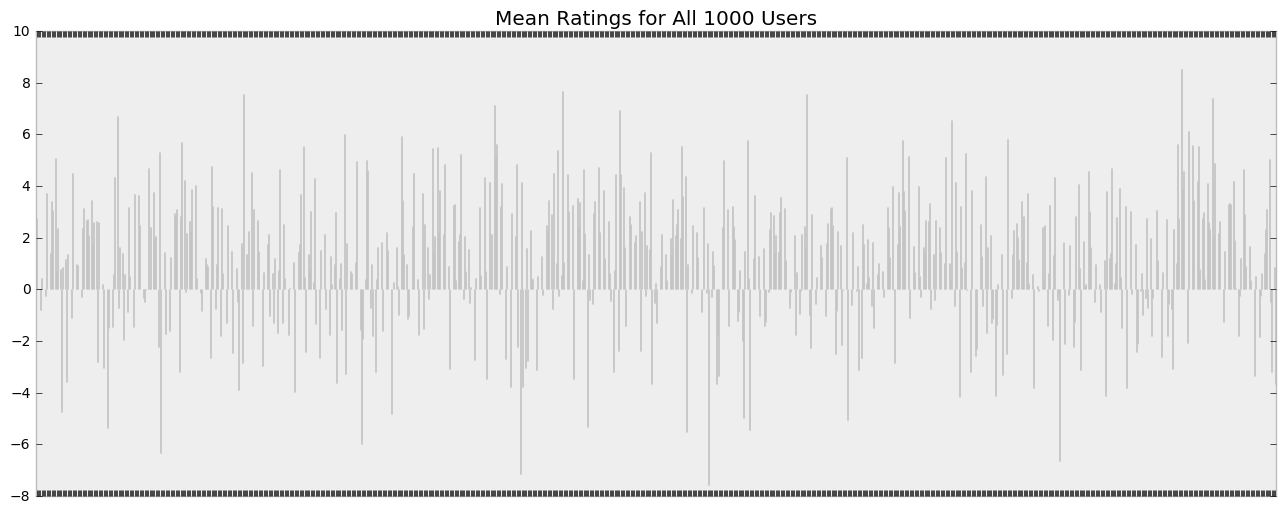

In [39]:
user_means = data.mean(axis=1)
_, ax = plt.subplots(figsize=(16, 6))
user_means.plot(kind='bar', grid=False, ax=ax,color='black',
                title="Mean Ratings for All 1000 Users")
ax.set_xticklabels('')  # 1000 labels is nonsensical

## Baseline models

If you come up with a decent idea for a model, then it makes sense to compare it to a baseline model or two or else how do you know it is good?

**goal** - Obtain lower RMSE scores with whatever model we produce

### Uniform Random Baseline

Replace every missing value with a uniform random number from the range [-10,10].

### Global Mean Baseline

Wherever we have a missing value, we’ll fill it in with the mean of all observed ratings

### Mean of Means Baseline

All users might rate some jokes more highly than others in general.  To try to capture these types of trends if we see a missing value in cell $R_{ij}$, we’ll average the global mean with the mean of $U_{i}$ and the mean of $V{j}$ and use that value to fill it in.

In [40]:
from collections import OrderedDict

# Create a base class with scaffolding for our 3 baselines.

def split_title(title):
    """Change "BaselineMethod" to "Baseline Method"."""
    words = []
    tmp = [title[0]]
    for c in title[1:]:
        if c.isupper():
            words.append(''.join(tmp))
            tmp = [c]
        else:
            tmp.append(c)
    words.append(''.join(tmp))
    return ' '.join(words)


class Baseline(object):
    """Calculate baseline predictions."""

    def __init__(self, train_data):
        """Simple heuristic-based transductive learning to fill in missing
        values in data matrix."""
        self.predict(train_data.copy())

    def predict(self, train_data):
        raise NotImplementedError(
            'baseline prediction not implemented for base class')

    def rmse(self, test_data):
        """Calculate root mean squared error for predictions on test data."""
        return rmse(test_data, self.predicted)

    def __str__(self):
        return split_title(self.__class__.__name__)



# Implement the 3 baselines.

class UniformRandomBaseline(Baseline):
    """Fill missing values with uniform random values."""

    def predict(self, train_data):
        nan_mask = np.isnan(train_data)
        masked_train = np.ma.masked_array(train_data, nan_mask)
        pmin, pmax = masked_train.min(), masked_train.max()
        N = nan_mask.sum()
        train_data[nan_mask] = np.random.uniform(pmin, pmax, N)
        self.predicted = train_data


class GlobalMeanBaseline(Baseline):
    """Fill in missing values using the global mean."""

    def predict(self, train_data):
        nan_mask = np.isnan(train_data)
        train_data[nan_mask] = train_data[~nan_mask].mean()
        self.predicted = train_data


class MeanOfMeansBaseline(Baseline):
    """Fill in missing values using mean of user/item/global means."""

    def predict(self, train_data):
        nan_mask = np.isnan(train_data)
        masked_train = np.ma.masked_array(train_data, nan_mask)
        global_mean = masked_train.mean()
        user_means = masked_train.mean(axis=1)
        item_means = masked_train.mean(axis=0)
        self.predicted = train_data.copy()
        n, m = train_data.shape
        for i in range(n):
            for j in range(m):
                if np.ma.isMA(item_means[j]):
                    self.predicted[i,j] = np.mean(
                        (global_mean, user_means[i]))
                else:
                    self.predicted[i,j] = np.mean(
                        (global_mean, user_means[i], item_means[j]))


baseline_methods = OrderedDict()
baseline_methods['ur'] = UniformRandomBaseline
baseline_methods['gm'] = GlobalMeanBaseline
baseline_methods['mom'] = MeanOfMeansBaseline

## Probabilistic Matrix Factorization

Check out the [NIPS paper](Probabilistic Matrix Factorization)

A probabilistic approach to the collaborative filtering problem that takes a Bayesian perspective. The ratings $R$ are modeled as draws from a Gaussian distribution. The mean for $R_{ij}$ is $U_{i} V^{T}_{j}$. 

The precision $\alpha$ is a fixed parameter that reflects the uncertainty of the estimations; the normal distribution is commonly reparameterized in terms of precision, which is the inverse of the variance.

Complexity is controlled by placing zero-mean spherical Gaussian priors on $U$ and $V$. In other words, each row of $U$ is drawn from a multivariate Gaussian with mean $\mu=0$ and precision which is some multiple of the identity matrix $I$.

Given small precision parameters, the priors on $U$ and $V$ ensure our latent variables do not grow too far from 0.  Controlling complexity like this helps prevent overfitting, which allows the model to generalize better for unseen data.

So the challenge becomes choosing appropriate values for $\alpha U$, $\alpha V$, and $\alpha$ and one can use soft weight sharing methods to address this (see documentation example for reference), but here we just use point estimates.

In [41]:
import time
import logging
import pymc3 as pm
import theano
import scipy as sp


# Enable on-the-fly graph computations, but ignore
# absence of intermediate test values.
theano.config.compute_test_value = 'ignore'

# Set up logging.
logger = logging.getLogger()
logger.setLevel(logging.INFO)


class PMF(object):
    """Probabilistic Matrix Factorization model using pymc3."""

    def __init__(self, train, dim, alpha=2, std=0.01, bounds=(-10, 10)):
        """Build the Probabilistic Matrix Factorization model using pymc3.

        :param np.ndarray train: The training data to use for learning the model.
        :param int dim: Dimensionality of the model; number of latent factors.
        :param int alpha: Fixed precision for the likelihood function.
        :param float std: Amount of noise to use for model initialization.
        :param (tuple of int) bounds: (lower, upper) bound of ratings.
            These bounds will simply be used to cap the estimates produced for R.

        """
        self.dim = dim
        self.alpha = alpha
        self.std = np.sqrt(1.0 / alpha)
        self.bounds = bounds
        self.data = train.copy()
        n, m = self.data.shape

        # Perform mean value imputation
        nan_mask = np.isnan(self.data)
        self.data[nan_mask] = self.data[~nan_mask].mean()

        # Low precision reflects uncertainty; prevents overfitting.
        # Set to the mean variance across users and items.
        self.alpha_u = 1 / self.data.var(axis=1).mean()
        self.alpha_v = 1 / self.data.var(axis=0).mean()

        # Specify the model.
        logging.info('building the PMF model')
        with pm.Model() as pmf:
            U = pm.MvNormal(
                'U', mu=0, tau=self.alpha_u * np.eye(dim),
                shape=(n, dim), testval=np.random.randn(n, dim) * std)
            V = pm.MvNormal(
                'V', mu=0, tau=self.alpha_v * np.eye(dim),
                shape=(m, dim), testval=np.random.randn(m, dim) * std)
            R = pm.Normal(
                'R', mu=theano.tensor.dot(U, V.T), tau=self.alpha * np.ones((n, m)),
                observed=self.data)

        logging.info('done building the PMF model')
        self.model = pmf

    def __str__(self):
        return self.name

### MAP estimate

Next we define some functions to calculate MAP estimates and do the sampling.  We use the MAP estimate to find a starting point for our MCMC sampling.  It takes some time so we save the result.

In [42]:
try:
    import ujson as json
except ImportError:
    import json

# First define functions to save our MAP estimate after it is found.
# We adapt these from `pymc3`'s `backends` module, where the original
# code is used to save the traces from MCMC samples.
def save_np_vars(vars, savedir):
    """Save a dictionary of numpy variables to `savedir`. We assume
    the directory does not exist; an OSError will be raised if it does.
    """
    logging.info('writing numpy vars to directory: %s' % savedir)
    if not os.path.isdir(savedir):
        os.mkdir(savedir)
    shapes = {}
    for varname in vars:
        data = vars[varname]
        var_file = os.path.join(savedir, varname + '.txt')
        np.savetxt(var_file, data.reshape(-1, data.size))
        shapes[varname] = data.shape

        ## Store shape information for reloading.
        shape_file = os.path.join(savedir, 'shapes.json')
        with open(shape_file, 'w') as sfh:
            json.dump(shapes, sfh)


def load_np_vars(savedir):
    """Load numpy variables saved with `save_np_vars`."""
    shape_file = os.path.join(savedir, 'shapes.json')
    with open(shape_file, 'r') as sfh:
        shapes = json.load(sfh)

    vars = {}
    for varname, shape in shapes.items():
        var_file = os.path.join(savedir, varname + '.txt')
        vars[varname] = np.loadtxt(var_file).reshape(shape)

    return vars


# Now define the MAP estimation infrastructure.
def _map_dir(self):
    basename = 'pmf-map-d%d' % self.dim
    return os.path.join(DATA_DIR, basename)

def _find_map(self):
    """Find mode of posterior using Powell optimization."""
    tstart = time.time()
    with self.model:
        logging.info('finding PMF MAP using Powell optimization...')
        self._map = pm.find_MAP(fmin=sp.optimize.fmin_powell, disp=True)

    elapsed = int(time.time() - tstart)
    logging.info('found PMF MAP in %d seconds' % elapsed)

    # This is going to take a good deal of time to find, so let's save it.
    save_np_vars(self._map, self.map_dir)

def _load_map(self):
    self._map = load_np_vars(self.map_dir)

def _map(self):
    try:
        return self._map
    except:
        if os.path.isdir(self.map_dir):
            self.load_map()
        else:
            self.find_map()
        return self._map


# Update our class with the new MAP infrastructure.
PMF.find_map = _find_map
PMF.load_map = _load_map
PMF.map_dir = property(_map_dir)
PMF.map = property(_map)

### Draw samples

In [43]:
# Draw MCMC samples.
def _trace_dir(self):
    basename = 'pmf-mcmc-d%d' % self.dim
    return os.path.join(DATA_DIR, basename)

def _draw_samples(self, nsamples=1000, njobs=2):
    # First make sure the trace_dir does not already exist.
    if os.path.isdir(self.trace_dir):
        shutil.rmtree(self.trace_dir)

    with self.model:
        logging.info('drawing %d samples using %d jobs' % (nsamples, njobs))
        backend = pm.backends.Text(self.trace_dir)
        logging.info('backing up trace to directory: %s' % self.trace_dir)
        self.trace = pm.sample(draws=nsamples, init='advi',
                               n_init=150000, njobs=njobs, trace=backend)

def _load_trace(self):
    with self.model:
        self.trace = pm.backends.text.load(self.trace_dir)


# Update our class with the sampling infrastructure.
PMF.trace_dir = property(_trace_dir)
PMF.draw_samples = _draw_samples
PMF.load_trace = _load_trace

## Define a function to make predictions

The function below simply draws an R matrix given a U and V and the fixed α stored in the PMF object

In [44]:
def _predict(self, U, V):
    """Estimate R from the given values of U and V."""
    R = np.dot(U, V.T)
    n, m = R.shape
    sample_R = np.array([
        [np.random.normal(R[i,j], self.std) for j in range(m)]
        for i in range(n)
    ])

    # bound ratings
    low, high = self.bounds
    sample_R[sample_R < low] = low
    sample_R[sample_R > high] = high
    return sample_R


PMF.predict = _predict

### Constrained version of PMF

One final thing to note: the dot products in this model are often constrained using a logistic function $g(x)=1/(1+exp(−x))$, that bounds the predictions to the range [0, 1]. To facilitate this bounding, the ratings are also mapped to the range [0, 1] using $t(x)=(x+min)/range$.

We finally need to define the formulat to calculate the RMSE.  RMSE can be thought of as the standard deviation of our predictions from the actual user preferences.

In [45]:
# Define our evaluation function.
def rmse(test_data, predicted):
    """Calculate root mean squared error.
    Ignoring missing values in the test data.
    """
    I = ~np.isnan(test_data)   # indicator for missing values
    N = I.sum()                # number of non-missing values
    sqerror = abs(test_data - predicted) ** 2  # squared error array
    mse = sqerror[I].sum() / N                 # mean squared error
    return np.sqrt(mse)                        # RMSE


### Training vs Test data

The next thing we need to do is split our data into a training set and a test set. Matrix factorization techniques use transductive learning rather than inductive learning. So we produce a test set by taking a random sample of the cells in the full N×M data matrix. The values selected as test samples are replaced with nan values in a copy of the original data matrix to produce the training set.

In [46]:
import hashlib


# Define a function for splitting train/test data.
def split_train_test(data, percent_test=10):
    """Split the data into train/test sets.
    :param int percent_test: Percentage of data to use for testing. Default 10.
    """
    n, m = data.shape             # # users, # jokes
    N = n * m                     # # cells in matrix
    test_size = N / percent_test  # use 10% of data as test set
    train_size = N - test_size    # and remainder for training

    # Prepare train/test ndarrays.
    train = data.copy().values
    test = np.ones(data.shape) * np.nan

    # Draw random sample of training data to use for testing.
    tosample = np.where(~np.isnan(train))       # ignore nan values in data
    idx_pairs = zip(tosample[0], tosample[1])   # tuples of row/col index pairs
    indices = np.arange(len(idx_pairs))         # indices of index pairs
    sample = np.random.choice(indices, replace=False, size=test_size)

    # Transfer random sample from train set to test set.
    for idx in sample:
        idx_pair = idx_pairs[idx]
        test[idx_pair] = train[idx_pair]  # transfer to test set
        train[idx_pair] = np.nan          # remove from train set

    # Verify everything worked properly
    assert(np.isnan(train).sum() == test_size)
    assert(np.isnan(test).sum() == train_size)

    # Finally, hash the indices and save the train/test sets.
    index_string = ''.join(map(str, np.sort(sample)))
    name = hashlib.sha1(index_string).hexdigest()
    savedir = os.path.join(DATA_DIR, name)
    save_np_vars({'train': train, 'test': test}, savedir)

    # Return train set, test set, and unique hash of indices.
    return train, test, name


def load_train_test(name):
    """Load the train/test sets."""
    savedir = os.path.join(DATA_DIR, name)
    vars = load_np_vars(savedir)
    return vars['train'], vars['test']

train, test, name = split_train_test(data)

INFO:root:writing numpy vars to directory: ./data/e6eb957c9c888ce1719c5d21c58479b13b8ee80d


## Run the models

In [47]:
# Let's see the results:
baselines = {}
for name in baseline_methods:
    Method = baseline_methods[name]
    method = Method(train)
    baselines[name] = method.rmse(test)
    print('%s RMSE:\t%.5f' % (method, baselines[name]))

Uniform Random Baseline RMSE:	7.80299
Global Mean Baseline RMSE:	5.24373
Mean Of Means Baseline RMSE:	4.78642


In [ ]:
# We use a fixed precision for the likelihood.
# This reflects uncertainty in the dot product.
# We choose 2 in the footsteps Salakhutdinov
# Mnihof.
ALPHA = 2

# The dimensionality D; the number of latent factors.
# We can adjust this higher to try to capture more subtle
# characteristics of each joke. However, the higher it is,
# the more expensive our inference procedures will be.
# Specifically, we have D(N + M) latent variables. For our
# Jester dataset, this means we have D(1100), so for 5
# dimensions, we are sampling 5500 latent variables.
DIM = 5

pmf = PMF(train, DIM, ALPHA, std=0.05)
print("done.")

INFO:root:building the PMF model
INFO:root:done building the PMF model


done.


In [ ]:
# Find MAP for PMF.
pmf.find_map()
print("done.")

INFO:root:finding PMF MAP using Powell optimization...


### Check to see if the MAP estimate is reasonable

In [ ]:
def eval_map(pmf_model, train, test):
    U = pmf_model.map['U']
    V = pmf_model.map['V']

    # Make predictions and calculate RMSE on train & test sets.
    predictions = pmf_model.predict(U, V)
    train_rmse = rmse(train, predictions)
    test_rmse = rmse(test, predictions)
    overfit = test_rmse - train_rmse

    # Print report.
    print('PMF MAP training RMSE: %.5f' % train_rmse)
    print('PMF MAP testing RMSE:  %.5f' % test_rmse)
    print('Train/test difference: %.5f' % overfit)

    return test_rmse


# Add eval function to PMF class.
PMF.eval_map = eval_map

In [ ]:
# Evaluate PMF MAP estimates.
pmf_map_rmse = pmf.eval_map(train, test)
pmf_improvement = baselines['mom'] - pmf_map_rmse
print('PMF MAP Improvement:   %.5f' % pmf_improvement)

## Make predictions

In [ ]:
# Draw MCMC samples.
pmf.draw_samples(300)

# uncomment to load previous trace rather than drawing new samples.
# pmf.load_trace()

### Diagnostics and Posterior Predictive Check

The next step is to check how many samples we should discard as burn-in. Normally, we’d do this using a traceplot to get some idea of where the sampled variables start to converge. In this case, we have high-dimensional samples, so we need to find a way to approximate them. One way was proposed by Salakhutdinov and Mnih, p.886.  (See reference in documentation)

def _norms(pmf_model, monitor=('U', 'V'), ord='fro'):
    """Return norms of latent variables at each step in the
    sample trace. These can be used to monitor convergence
    of the sampler.
    """
    monitor = ('U', 'V')
    norms = {var: [] for var in monitor}
    for sample in pmf_model.trace:
        for var in monitor:
            norms[var].append(np.linalg.norm(sample[var], ord))
    return norms


def _traceplot(pmf_model):
    """Plot Frobenius norms of U and V as a function of sample #."""
    trace_norms = pmf_model.norms()
    u_series = pd.Series(trace_norms['U'])
    v_series = pd.Series(trace_norms['V'])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    u_series.plot(kind='line', ax=ax1, grid=False,
                  title="$\|U\|_{Fro}^2$ at Each Sample")
    v_series.plot(kind='line', ax=ax2, grid=False,
                  title="$\|V\|_{Fro}^2$ at Each Sample")
    ax1.set_xlabel("Sample Number")
    ax2.set_xlabel("Sample Number")


PMF.norms = _norms
PMF.traceplot = _traceplot

In [ ]:
pmf.traceplot()

### Convergence

It appears we get convergence of U and V after about 200 samples. When testing for convergence, we also want to see convergence of the particular statistics we are looking for, since different characteristics of the posterior may converge at different rates. Let’s also do a traceplot of the RSME.

In [ ]:
def _running_rmse(pmf_model, test_data, train_data, burn_in=0, plot=True):
    """Calculate RMSE for each step of the trace to monitor convergence.
    """
    burn_in = burn_in if len(pmf_model.trace) >= burn_in else 0
    results = {'per-step-train': [], 'running-train': [],
               'per-step-test': [], 'running-test': []}
    R = np.zeros(test_data.shape)
    for cnt, sample in enumerate(pmf_model.trace[burn_in:]):
        sample_R = pmf_model.predict(sample['U'], sample['V'])
        R += sample_R
        running_R = R / (cnt + 1)
        results['per-step-train'].append(rmse(train_data, sample_R))
        results['running-train'].append(rmse(train_data, running_R))
        results['per-step-test'].append(rmse(test_data, sample_R))
        results['running-test'].append(rmse(test_data, running_R))

    results = pd.DataFrame(results)

    if plot:
        results.plot(
            kind='line', grid=False, figsize=(15, 7),
            title='Per-step and Running RMSE From Posterior Predictive')

    # Return the final predictions, and the RMSE calculations
    return running_R, results

PMF.running_rmse = _running_rmse

In [ ]:
predicted, results = pmf.running_rmse(test, train, burn_in=200)

In [ ]:
# And our final RMSE?
final_test_rmse = results['running-test'].values[-1]
final_train_rmse = results['running-train'].values[-1]
print('Posterior predictive train RMSE: %.5f' % final_train_rmse)
print('Posterior predictive test RMSE:  %.5f' % final_test_rmse)
print('Train/test difference:           %.5f' % (final_test_rmse - final_train_rmse))
print('Improvement from MAP:            %.5f' % (pmf_map_rmse - final_test_rmse))
print('Improvement from Mean of Means:  %.5f' % (baselines['mom'] - final_test_rmse))

In [ ]:
### Results summary

In [ ]:

size = 100  # RMSE doesn't really change after 100th sample anyway.
all_results = pd.DataFrame({
    'uniform random': np.repeat(baselines['ur'], size),
    'global means': np.repeat(baselines['gm'], size),
    'mean of means': np.repeat(baselines['mom'], size),
    'PMF MAP': np.repeat(pmf_map_rmse, size),
    'PMF MCMC': results['running-test'][:size],
})
fig, ax = plt.subplots(figsize=(10, 5))
all_results.plot(kind='line', grid=False, ax=ax,
                 title='RMSE for all methods')
ax.set_xlabel("Number of Samples")
ax.set_ylabel("RMSE")